In [1]:
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
import fitsio as ft
import lssutils.utils as ut
import numpy as np
import matplotlib.pyplot as plt

## prep

In [6]:
# run once
d = ft.read('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits')

dt_c = ut.split2KfoldsSpatially(d, random_seed=42)
dt_r = ut.split2kfolds(d, seed=42)

np.save('/home/mehdi/data/tanveer/test_split/dr8split_continous', dt_c)
np.save('/home/mehdi/data/tanveer/test_split/dr8split_random', dt_r)

## viz

In [2]:
dt_c = np.load('/home/mehdi/data/tanveer/test_split/dr8split_continous.npy', allow_pickle=True)
dt_r = np.load('/home/mehdi/data/tanveer/test_split/dr8split_random.npy', allow_pickle=True)

In [3]:
def plot_scatter(dd):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    
    for set_ in ['train', 'validation', 'test']:
                
        ra_t, dec_t = ut.hpix2radec(256, dd[set_]['fold0']['hpix'])    
        ax[0].scatter(ut.shiftra(ra_t), dec_t)
        
        ax[1].hist(dd[set_]['fold0']['features'][:, 1], alpha=0.6, histtype='step')

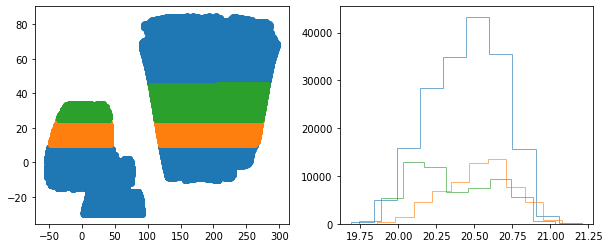

In [4]:
plot_scatter(dt_c.item())

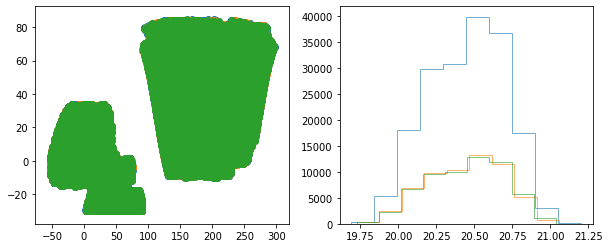

In [5]:
plot_scatter(dt_r.item())

In [6]:
mt = np.load('/home/mehdi/data/tanveer/test_split/continous/metrics.npz', allow_pickle=True)
mt2 = np.load('/home/mehdi/data/tanveer/test_split/random/metrics.npz', allow_pickle=True)

Text(0, 0.5, 'Test Loss')

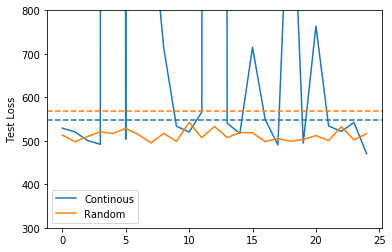

In [7]:
def plot_losses(ax, mt_, c, n):    
    ax.plot(np.array(mt_['losses'].item()['test'][0]), color=c, label=n)
    ax.axhline(mt_['stats'].item()[0]['base_test_loss'], ls='--', color=c)

fig, ax = plt.subplots()

plot_losses(ax, mt, 'C0', 'Continous')
plot_losses(ax, mt2, 'C1', 'Random')

ax.legend()
ax.set_ylim(300., 800.)
ax.set_ylabel(r'Test Loss')

In [8]:
from scipy.stats import pearsonr
from lssutils.dataviz import setup_color

In [9]:
d = ft.read('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits')

In [10]:
from lssutils.stats.nnbar import MeanDensity

In [11]:
def make_hp(hpix, value):
    map_ = np.zeros(12*256*256)
    map_[hpix] = value
    return map_

In [12]:
ng = make_hp(d['hpix'], d['label'])
nr = make_hp(d['hpix'], d['fracgood'])
sy = make_hp(d['hpix'], d['features'][:, 1])
mask = make_hp(d['hpix'], 1.0).astype('bool')

In [13]:
wnn = ft.read('/home/mehdi/data/tanveer/test_split/random/nn-weights.fits')
wr = make_hp(wnn['hpix'], wnn['weight'].mean(axis=1))
maskr = make_hp(wnn['hpix'], 1.0) > 0

In [14]:
wnn_ = ft.read('/home/mehdi/data/tanveer/test_split/continous/nn-weights.fits')
wc = make_hp(wnn_['hpix'], wnn_['weight'].mean(axis=1))
maskc = make_hp(wnn_['hpix'], 1.0) > 0

In [15]:
mask_com = mask & maskr & maskc

In [28]:
md = MeanDensity(ng, nr, mask_com, sy, nbins=10)
md.run()

mdr = MeanDensity(wr*nr, nr, mask_com, sy, nbins=10)
mdr.run()

mdc = MeanDensity(wc*nr, nr, mask_com, sy, nbins=10)
mdc.run()

In [19]:
setup_color()

In [36]:
md.output

{'nnbar': array([1.05243837, 1.03961485, 1.04679188, 1.03235736, 1.01345091,
        1.00451275, 0.98520002, 0.96128205, 0.94495793, 0.91938207]),
 'area': array([30249.83614713, 30250.06919177, 30250.1182538 , 30250.19593535,
        30250.58843158, 30250.40036047, 30249.77073109, 30250.22455486,
        30250.32267892, 30245.47371501]),
 'nnbar_err': array([0.00256317, 0.0008455 , 0.00102613, 0.00248622, 0.00133144,
        0.00095848, 0.00196763, 0.00145968, 0.001848  , 0.00328345]),
 'bin_edges': array([19.6889075 , 20.10247475, 20.20512994, 20.29291162, 20.38384048,
        20.46470474, 20.53404998, 20.6004851 , 20.66760833, 20.75488669,
        21.20586657]),
 'bin_avg': array([20.01393863, 20.15635616, 20.24907422, 20.33823644, 20.42602256,
        20.49994463, 20.56698101, 20.63352045, 20.70841205, 20.83340499]),
 'attr': {'njack': 20,
  'nbar': 135.6688341411875,
  'npix2area': 0.995050048195557}}

Text(0.5, 0, '$\\log {\\rm HI}$')

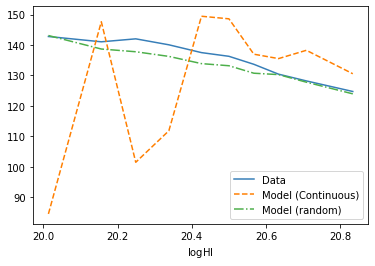

In [47]:
for mdi in [md, mdc, mdr]:
    plt.plot(mdi.output['bin_avg'], mdi.output['nnbar']*mdi.output['attr']['nbar'])

plt.legend(['Data', 'Model (Continuous)', 'Model (random)'])
plt.xlabel(r'$\log {\rm HI}$')

In [40]:
from scipy.stats import binned_statistic

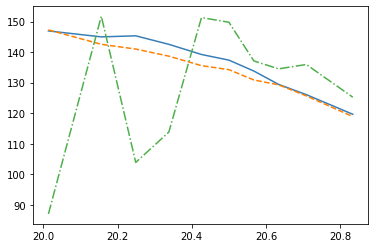

In [46]:
for n_i in [ng, wr*nr, wc*nr]:
    y_,_,_ = binned_statistic(sy[mask_com], n_i[mask_com], bins=md.output['bin_edges'])
    plt.plot(md.output['bin_avg'], y_)

In [44]:
binned_statistic(sy[mask_com], (wr*nr)[mask_com], bins=md.output['bin_edges'])

BinnedStatisticResult(statistic=array([147.26536657, 142.54379871, 140.98926652, 138.66406901,
       135.55729741, 134.24331185, 130.86063734, 129.28559081,
       125.6415711 , 118.88810823]), bin_edges=array([19.6889075 , 20.10247475, 20.20512994, 20.29291162, 20.38384048,
       20.46470474, 20.53404998, 20.6004851 , 20.66760833, 20.75488669,
       21.20586657]), binnumber=array([10, 10, 10, ...,  3,  4,  3]))

In [45]:
binned_statistic(sy[mask_com], (wc*nr)[mask_com], bins=md.output['bin_edges'])

BinnedStatisticResult(statistic=array([ 86.98378505, 151.74262758, 103.84931867, 113.81612099,
       151.30805124, 149.77212751, 137.11136564, 134.50253173,
       135.93734185, 125.2176028 ]), bin_edges=array([19.6889075 , 20.10247475, 20.20512994, 20.29291162, 20.38384048,
       20.46470474, 20.53404998, 20.6004851 , 20.66760833, 20.75488669,
       21.20586657]), binnumber=array([10, 10, 10, ...,  3,  4,  3]))

In [33]:
from lssutils.dataviz import hpmollview, mycolor

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


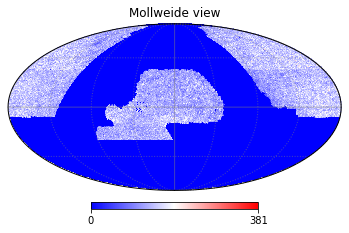

In [32]:
fig, ax = plt.subplots()
hpmollview(ng, '', [fig, ax], )

In [21]:
md_wr = MeanDensity(ng, nr, mask_com, sy, selection=wr/wr[mask_com].mean())
md_wr.run()

In [22]:
md_wc = MeanDensity(ng, nr, mask_com, sy, selection=wc/wc[mask_com].mean())
md_wc.run()

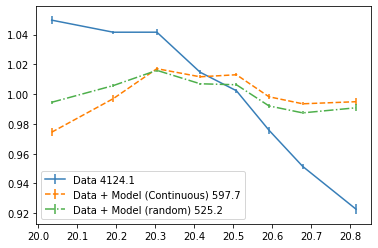

In [26]:

for mdi, ni in zip([md, md_wc, md_wr],
                   ['Data', 'Data + Model (Continuous)', 'Data + Model (random)']):
    sum_ch2 =  (((mdi.output['nnbar']-1)/mdi.output['nnbar_err'] )**2.0).sum()
    
    plt.errorbar(mdi.output['bin_avg'], mdi.output['nnbar'], mdi.output['nnbar_err'],
             label=f'{ni} {sum_ch2:.1f}')

    
plt.legend()